In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from madgwickahrs import * 
from quaternion import Quaternion
from conversion import * 

In [2]:
data = pd.read_csv('20180524-192530-MTCC1_all.csv',  encoding = "ISO-8859-1")
# header = data.columns.values
# print(header)

In [3]:
header = data.columns.values
print(header)
print(len(data))
short_len = int(len(data))
print(short_len)

['Date (UTC)' 'Time (UTC)' ' Date (local)' ' Time (local)'
 'Accelerometer X [m/s²]' 'Accelerometer Y [m/s²]'
 'Accelerometer Z [m/s²]' 'Gyroscope X [mrad/s]' 'Gyroscope Y [mrad/s]'
 'Gyroscope Z [mrad/s]' 'Magnetometer X [µT]' 'Magnetometer Y [µT]'
 'Magnetometer Z [µT]' 'Temperature (imu) [°C]' 'Depth (100bar) 1 [m]'
 'Depth (100bar) 2 [°C]' 'Light intensity 1 [raw]'
 'Light intensity 2 [raw]' 'System error' 'BATT [V]' 'BATT [mA]'
 'BATT [mAh]' 'Camera' 'Flags' 'LED' 'Camera time' 'CC status'
 ' CC vid. size [kBytes]']
1723311
1723311


In [4]:
short_data = data.head(n=short_len)#cv 
ax = short_data['Accelerometer X [m/s²]'].tolist()
ay = short_data['Accelerometer Y [m/s²]'].tolist()
az = short_data['Accelerometer Z [m/s²]'].tolist()
gx = short_data['Gyroscope X [mrad/s]'].tolist()
gy = short_data['Gyroscope Y [mrad/s]'].tolist()
gz = short_data['Gyroscope Z [mrad/s]'].tolist()
depth = short_data['Depth (100bar) 2 [°C]'].tolist()


In [13]:
with  open('esl_groundtrugthdata_axayazgxgygzdepth.csv' , 'w') as thefile:
    thefile.write("Accelerometer X [m/s²],Accelerometer Y [m/s²],Accelerometer Z [m/s²],Gyroscope X [mrad/s],Gyroscope Y [mrad/s],Gyroscope Z [mrad/s],Depth (100bar) 2 [°C]\n")
    for i in range(len(ax)):
        thefile.write("%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f\n" %  (ax[i], ay[i], az[i], gx[i], gy[i], gz[i], depth[i]))

In [14]:
Acc = []
Gyro = []
for i in range(len(ax)):
    Acc.append([ax[i], ay[i], az[i]])
    Gyro.append([np.array(gx[i])/1000, np.array(gy[i])/1000, np.array(gz[i])/1000])



In [15]:
del ax, ay, az
del gx, gy, gz 
del data
del short_data

In [16]:
frequency = 256
sampleperiod = 1/frequency

roll = []
pitch = []
yaw = []
rot_mat = []
Imupredict = MadgwickAHRS()
Imupredict.sampleperiod = sampleperiod

def conj(q):
    return [q[0], -q[1], -q[2], -q[3]]

def to_euler_angles(self):
    pitch = np.arcsin(2 * self[1] * self[2] + 2 * self[0] * self[3])
    if np.abs(self[1] * self[2] + self[3] * self[0] - 0.5) < 1e-8:
        roll = 0
        yaw = 2 * np.arctan2(self[1], self[0])
    elif np.abs(self[1] * self[2] + self[3] * self[0] + 0.5) < 1e-8:
        roll = -2 * np.arctan2(self[1], self[0])
        yaw = 0
    else:
        roll = np.arctan2(2 * self[0] * self[1] - 2 * self[2] * self[3], 1 - 2 * self[1] ** 2 - 2 * self[3] ** 2)
        yaw = np.arctan2(2 * self[0] * self[2] - 2 * self[1] * self[3], 1 - 2 * self[2] ** 2 - 2 * self[3] ** 2)
    return roll, pitch, yaw


for i in range(len(Acc)):
    Imupredict.update_imu( Gyro[i], Acc[i])
    q = Imupredict.quaternion
    rot_mat.append( np.transpose(quaterniontorotmatrix(q)))
    q1 = conj(q)
    q2 = to_euler_angles(q1)
    roll.append(q2[0])
    pitch.append(q2[1])
    yaw.append(q2[2])
    
roll = np.array(roll)*(180/math.pi)
pitch = np.array(pitch)*(180/math.pi)
yaw = np.array(yaw)*(180/math.pi)



In [17]:
Earth_acc = []
for i in range(len(Acc)):
    Earth_acc.append(rot_mat[i]*np.transpose([Acc[i]]))

In [18]:
del Acc, Gyro

In [19]:
linear_acc = []
for i in range(len(Earth_acc)):
    linear_acc.append(Earth_acc[i]- [[0],[0],[9.8]])

In [20]:
linear_vel = []
prev = np.array([[0],[0],[0]])
linear_vel.append(prev)


for i in range(len(linear_acc)):
    if i == 0:
        pass
    else:
        vel = prev + linear_acc[i]*sampleperiod
        linear_vel.append(vel)
        prev = vel


In [21]:
linear_pos = []
prev = np.array([[0],[0],[0]])
linear_pos.append(prev)


for i in range(len(linear_vel)):
    if i == 0:
        pass
    else:
        pos = prev + linear_vel[i]*sampleperiod
        linear_pos.append(pos)
        prev = pos


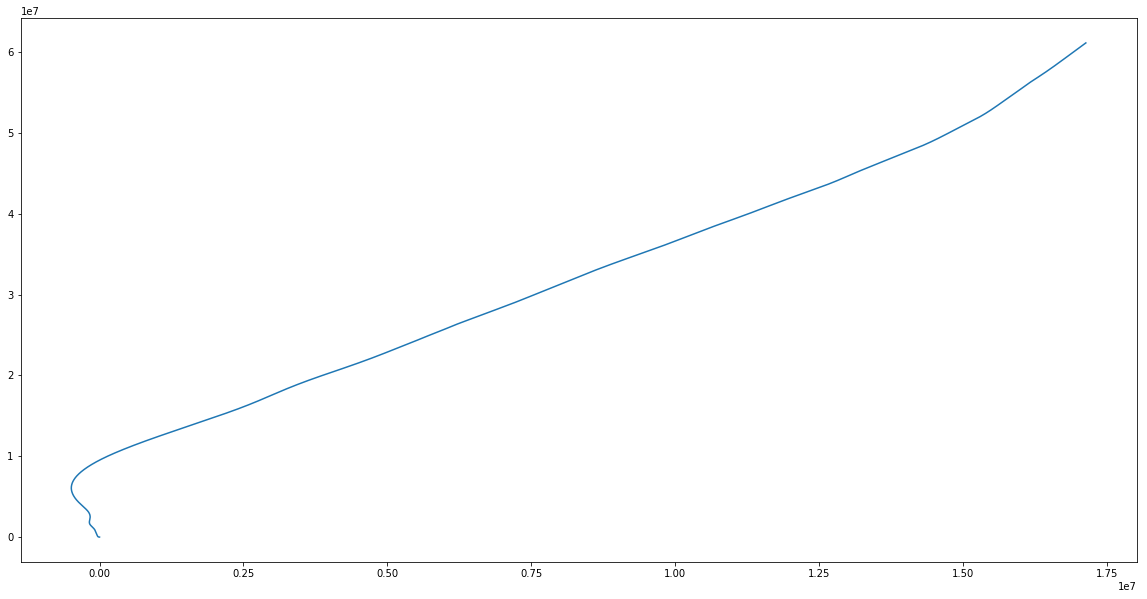

In [22]:
x = []
y = []
z = []

for i in range(len(linear_pos)):
    x.append(linear_pos[i][0][0])
    y.append(linear_pos[i][1][0])
    z.append(linear_pos[i][2][0])
    
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
plt.plot(x, y)
plt.show()

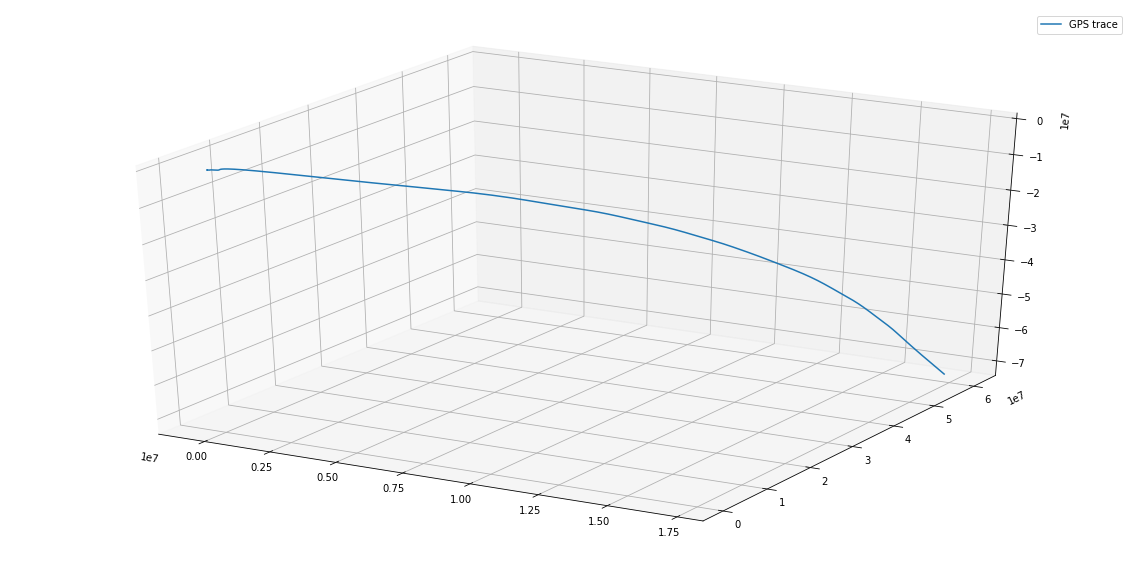

In [38]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

#mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure(figsize=(20,10))
aplot = fig.gca(projection='3d')
aplot.plot(x, y, z, label='GPS trace')
aplot.legend()

plt.show()


In [33]:
len(linear_vel)
len(linear_acc)
len(yaw)

1723311

In [37]:
with  open('esl_groundtrugthdata_eulerearthlinearavp.csv' , 'w') as thefile:
    thefile.write("roll,pitch,yaw, earth_aX, earth_aY, earth_aZ, linear_aX, linear_aY, linear_aZ, vx, vy, vz, px, py, pz \n")
    for i in range(len(yaw)):
        thefile.write("%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f\n" %  (roll[i],pitch[i],yaw[i], Earth_acc[i][0], Earth_acc[i][1], Earth_acc[i][2],linear_acc[i][0], linear_acc[i][1], linear_acc[i][2], linear_vel[i][0], linear_vel[i][1], linear_vel[i][2], linear_pos[i][0], linear_pos[i][1], linear_pos[i][2]))
        
        
        